The notebook contains descriptive statistics and visualizations regarding rental prices, flow of publications on the Avito website and commissions charged by agents. The plots are quite self-explanatory, so the amount of comments is kept to a minimum. Comments are always placed above the cell they relate to.

In [62]:
import datetime
import pathlib

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sb

%matplotlib inline

In [63]:
PROJECT_FOLDER_PATH = pathlib.Path().resolve().parent
EDA_DF_PATH = PROJECT_FOLDER_PATH / 'data/interim/eda_df.csv'

In [64]:
df = pd.read_csv(EDA_DF_PATH, index_col=0, parse_dates=['parsing_date', 'pub_date', 'pub_time'])

To avoid the influence of seasonality I will restrict the observation period to 2 weeks and leave only the ads published after August 1.

In [65]:
df = df[df['pub_date'] >= pd.to_datetime('2020-08-01')]

In [67]:
#short description of the dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 11720 entries, /moskva/kvartiry/1-k_kvartira_34_m_89_et._1973513833 to /moskva/kvartiry/2-k_kvartira_70_m_1920_et._1184902564
Data columns (total 16 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   commission_percent  6941 non-null   float64       
 1   station_distance    11720 non-null  int64         
 2   rent                11720 non-null  float64       
 3   pub_date            11720 non-null  datetime64[ns]
 4   pub_time            8138 non-null   datetime64[ns]
 5   studio              11720 non-null  int64         
 6   n_rooms             11720 non-null  int64         
 7   area                11720 non-null  int64         
 8   floor               11720 non-null  int64         
 9   n_floors            11720 non-null  int64         
 10  n_days              7192 non-null   float64       
 11  mcc                 11720 non-null  int64         
 12  circle 

In [68]:
#Number of missing values by column
df.isna().sum()

commission_percent    4779
station_distance         0
rent                     0
pub_date                 0
pub_time              3582
studio                   0
n_rooms                  0
area                     0
floor                    0
n_floors                 0
n_days                4528
mcc                      0
circle                   0
center_distance          0
parsing_date             0
y                        0
dtype: int64

## Prices

In [69]:
prices_by_rooms = (df[['pub_date', 'rent', 'y', 'n_rooms']]
                   .groupby(['pub_date', 'n_rooms'])
                   .median()
                   .unstack())

The supply of 4 and 5-room flats is so little that every new flat entering the market can shift the median prices. The rental cost of 1 and 2-room flats is much more stable and is always between 0.8 and 1 thousand roubles per square meter.

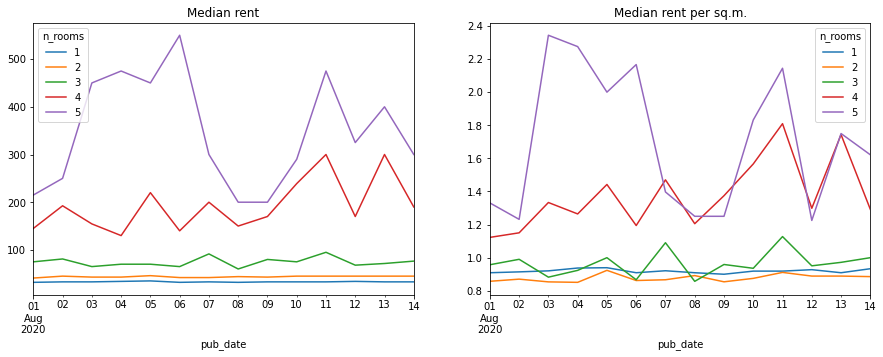

In [70]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
prices_by_rooms['rent'].plot(ax=axes[0], title='Median rent')
prices_by_rooms['y'].plot(ax=axes[1], title='Median rent per sq.m.')
plt.show()

Interestingly, rent per square meter does not decrease as number of rooms grows. Prices above 4 thousand per square meter are outliers for any number of rooms.

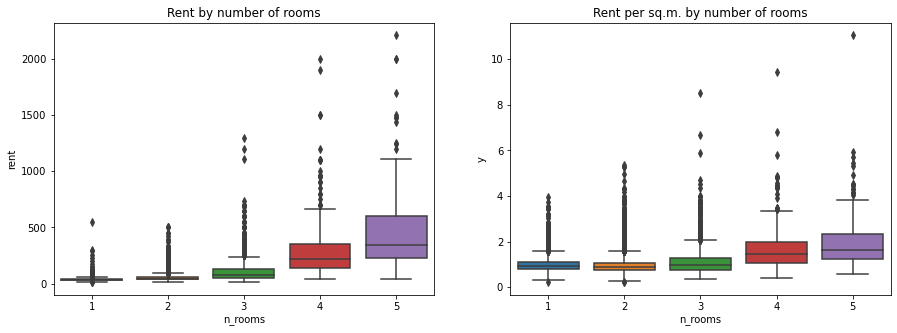

In [71]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
sb.boxplot('n_rooms', 'rent', data=df)
plt.title('Rent by number of rooms')
plt.subplot(1, 2, 2)
sb.boxplot('n_rooms', 'y', data=df)
plt.title('Rent per sq.m. by number of rooms')
plt.show()

Without the outliers the box-plots are seen more clearly. Distributions of all prices tend to be right-skewed, the most notably for 5-bedroom apartments.

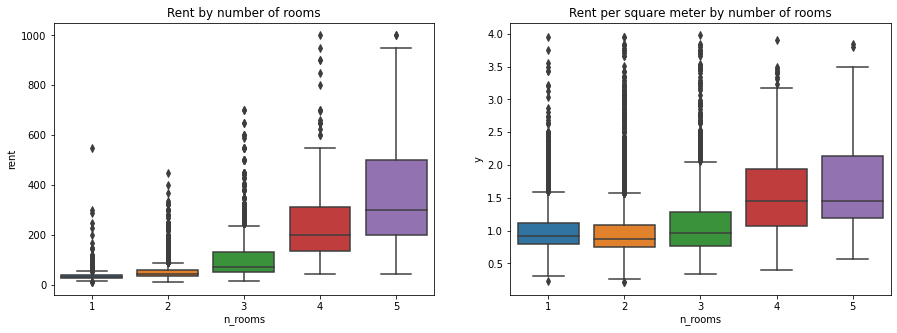

In [72]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
sb.boxplot('n_rooms', 'rent', data=df[df['y']<4])
plt.title('Rent by number of rooms')
plt.subplot(1, 2, 2)
sb.boxplot('n_rooms', 'y', data=df[df['y']<4])
plt.title('Rent per square meter by number of rooms')
plt.show()

Rental prices have moderate negative correlation with distance to the closest station and remoteness to the city center. It seems like bigger flats do not have smaller price per square meter. 

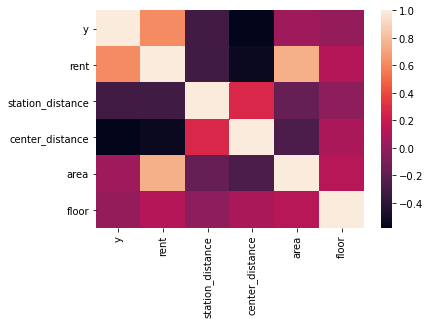

In [73]:
corr_cols = ['y', 'rent', 'station_distance', 'center_distance', 'area', 'floor']
sb.heatmap(df[corr_cols].corr('spearman'))
plt.show()

Rent per square meter among flats near circle stations is notably higher. The influence of being near Moscow central circle on price is not obvious.

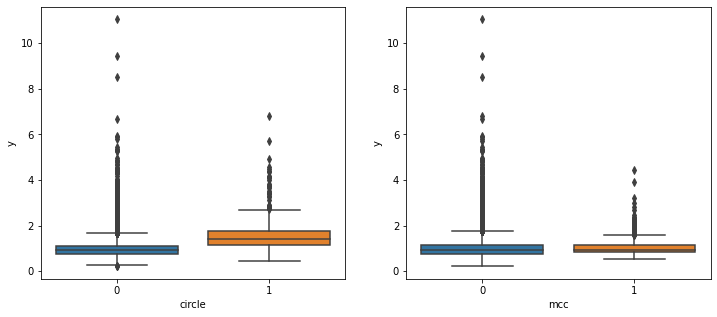

In [74]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sb.boxplot('circle', 'y', data=df)
plt.subplot(1, 2, 2)
sb.boxplot('mcc', 'y', data=df)

## Publication flow

In [75]:
count_by_rooms = df.groupby(['pub_date', 'n_rooms']).count().unstack()

On average, 800-900 flats enter the market daily. 35-45% of them are 1-room and 35-40% are 2-room. 4 and 5-room flats together never account for more than 10% of the market. Publication activity slows down at weekends (August 1, 2, 8 and 9).

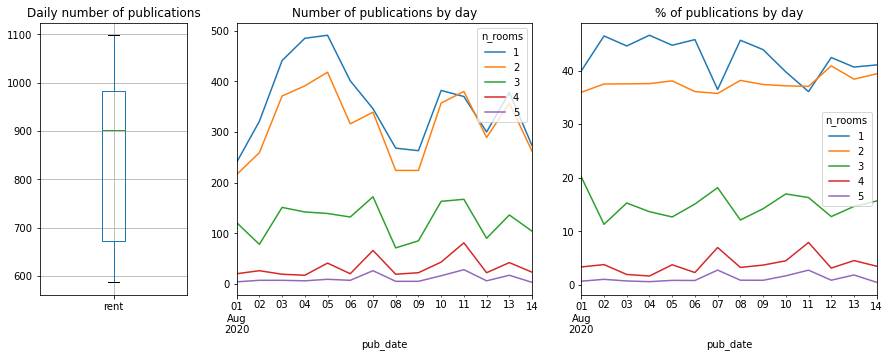

In [76]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5), gridspec_kw={'width_ratios': [1, 2, 2]})
df.groupby('pub_date').count().boxplot(column='rent', ax=axes[0])
axes[0].set_title('Daily number of publications')
count_by_rooms['rent'].plot(title='Number of publications by day', ax=axes[1])
((pd.crosstab(df['pub_date'], df['n_rooms'], normalize='index')*100)
 .plot(title='% of publications by day', ax=axes[2]))
plt.show()

In [77]:
df['pub_hour'] = df['pub_time'].dt.hour

About a half of ads is published between 10 a.m. and 18 p.m. The average rate of publications flow during that period is 50 to 70 ads per hour. Only 10% of ads is published in night hours.

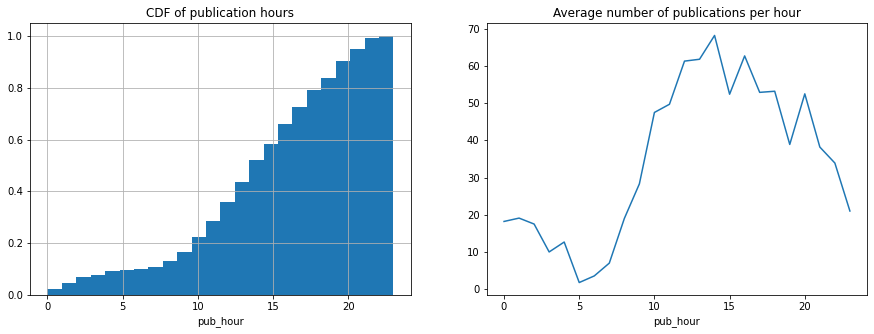

In [78]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
df['pub_hour'].hist(bins=24, density=True, cumulative=True, ax=axes[0])
axes[0].set_title('CDF of publication hours')
axes[0].set_xlabel('pub_hour')
(df.groupby(['pub_hour', 'pub_date'])
 .count()
 .groupby('pub_hour')
 .mean()['rent']
 .plot(title='Average number of publications per hour', ax=axes[1]))
plt.show()

A half of ads remains on the site for more than 4 days. Only 10% of ads wait more than 8 days before deletion. Flats near circle stations find renters faster.

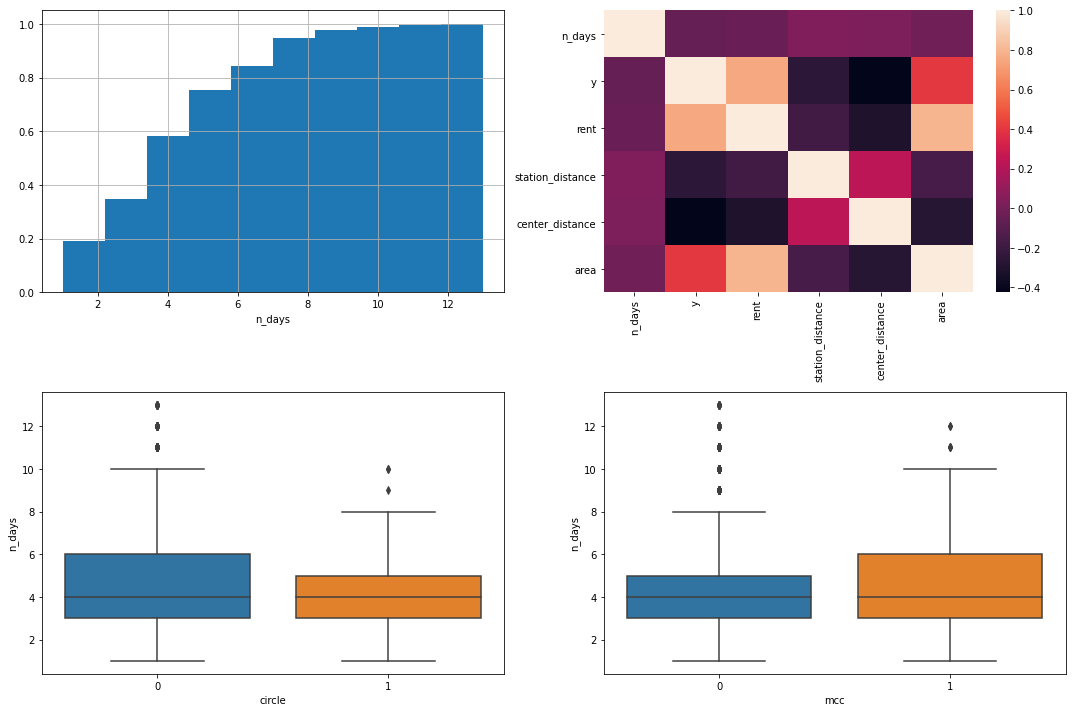

In [91]:
plt.figure(figsize=(15, 10))
plt.subplot(2, 2, 1)
df['n_days'].hist(density=True, cumulative=True)
plt.xlabel('n_days')
plt.subplot(2, 2, 2)
corr_cols = ['n_days', 'y', 'rent', 'station_distance', 'center_distance', 'area']
sb.heatmap(df[corr_cols].corr())
plt.subplot(2, 2, 3)
sb.boxplot('circle', 'n_days', data=df)
plt.subplot(2, 2, 4)
sb.boxplot('mcc', 'n_days', data=df)
plt.tight_layout()
plt.show()

## Commissions

The more rooms the flat has, the lower is the commission relative to its rental price. Almost a half of the flats are rented with 50% commission. A quarter of ads are commission-free (which can be considered to be an upper bound of the share of flats rented without agent intermediation). All other options account for less than 10% of flats each.

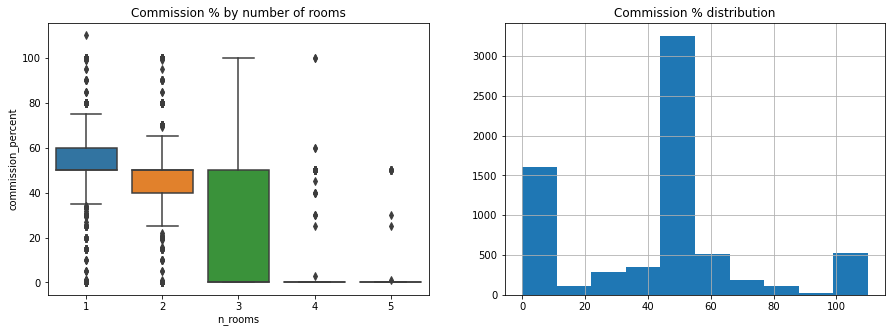

In [80]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
sb.boxplot('n_rooms', 'commission_percent', data=df); plt.title('Commission % by number of rooms')
plt.subplot(1, 2, 2)
df['commission_percent'].hist(); plt.title('Commission % distribution')
plt.show()

In [81]:
commission_freq = (df['commission_percent'].value_counts(normalize=True)
                                           .head().round(2)
                                           .to_frame('share of flats'))
commission_freq.index.name = 'Commission %'
commission_freq

,share of flats
Commission %,
50.0,0.46
0.0,0.23
100.0,0.07
60.0,0.06
40.0,0.04


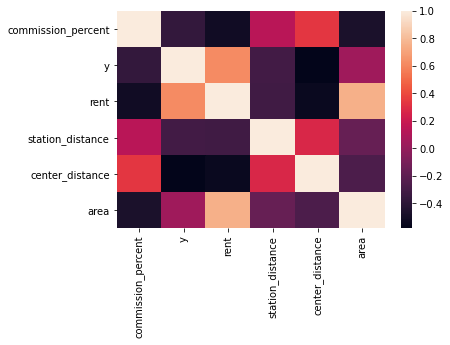

In [82]:
corr_cols = ['commission_percent', 'y', 'rent', 'station_distance', 'center_distance', 'area']
sb.heatmap(df[corr_cols].corr('spearman'))
plt.show()